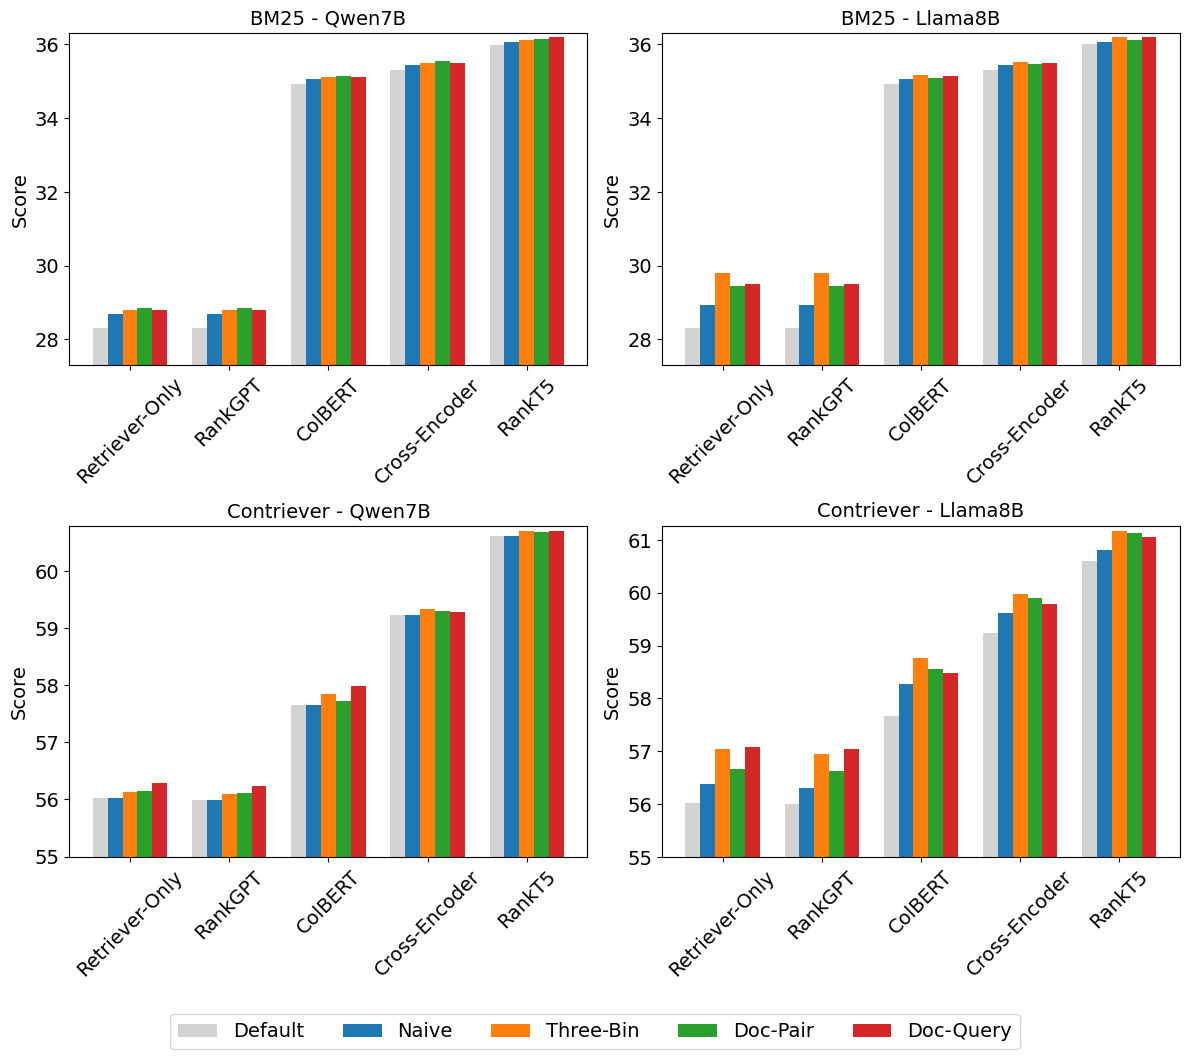

In [1]:
from collections import defaultdict
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

reranker_mapping = {
    '': 'Retriever-Only',
    'rankgpt': 'RankGPT',
    'rankgpt-qwen7b': 'RankGPT',
    'rankgpt-llama8b': 'RankGPT',
    'colbert': 'ColBERT',
    'cross-encoder': 'Cross-Encoder',
    't5': 'RankT5'
}
dataset_mapping = {
    'nq': 'NaturalQuestions',
    'hotpotqa': 'HotpotQA',
    'dbpedia-entity': 'DBPedia-Entity',
    'fever': 'FEVER',
    'avg': 'Average'
}
method_mapping = {
    '': 'Default',
    'naive': 'Naive',
    'three_bins': 'Three-Bin',
    'doc_diff_score': 'Doc-Pair',
    'doc_query_diff': 'Doc-Query'
}
model_mapping = {
    "qwen7b": "Qwen7B",
    "llama8b": "Llama8B"
}
retriever_mapping = {
    "bm25": "BM25",
    "contriever": "Contriever"
}

filter_dataset_names = ['nq', 'hotpotqa', 'dbpedia-entity', 'fever']
figure_dir = 'data/new'
os.makedirs(figure_dir, exist_ok=True)
best_scores_path = 'data/raw//all_best_scores.xlsx'

# Read data from Excel file using pandas
column_names = ['dataset_name', 'retriever', 'reranker', 'model', 'method', 'measure_key', 'NDCG@10']
column_types = {
    'dataset_name': str,
    'retriever': str,
    'reranker': str,
    'model': str,
    'method': str,
    'measure_key': str,
    'NDCG@10': float
}

# excel -> df
df = pd.read_excel(best_scores_path, usecols=column_names, dtype=column_types)
df = df[df['dataset_name'].isin(filter_dataset_names)]
df = df[df['measure_key'] == 'mscp']
# default values
df['dataset_name'] = df['dataset_name'].fillna('')
df['retriever'] = df['retriever'].fillna('')
df['reranker'] = df['reranker'].fillna('')
df['model'] = df['model'].fillna('')
df['method'] = df['method'].fillna('')

# df -> dict
all_scores = {}
for index, row in df.iterrows():
    dataset_name = row['dataset_name']
    retriever = row['retriever']
    reranker = row['reranker']
    model = row['model']
    method = row['method']
    ndcg_score = row['NDCG@10']
    # print(dataset_name, retriever, reranker, model, method, ndcg_score)
    all_scores.setdefault(model, {})
    all_scores[model].setdefault(retriever, {})
    all_scores[model][retriever].setdefault(reranker, {})
    all_scores[model][retriever][reranker].setdefault(method, {})
    all_scores[model][retriever][reranker][method][dataset_name] = ndcg_score

# Calculate average scores across datasets
for model in all_scores:
    for retriever in all_scores[model]:
        for reranker in all_scores[model][retriever]:
            for method in all_scores[model][retriever][reranker]:
                scores = all_scores[model][retriever][reranker][method]
                avg_score = sum(scores.values()) / len(scores)
                all_scores[model][retriever][reranker][method]['avg'] = avg_score

draw_scores = {'qwen7b': {}, 'llama8b': {}}
for model in ('qwen7b', 'llama8b'):
    for prev_name in ('bm25', 'contriever'):
        draw_scores[model][prev_name] = {}
        prev_scores = all_scores[model][prev_name]
        for reranker_name in ['', f'rankgpt-{model}', 'colbert', 'cross-encoder', 't5']:
            for our_name in ['', 'naive', 'three_bins', 'doc_diff_score', 'doc_query_diff']:
                scores = prev_scores[reranker_name][our_name]
                draw_scores[model][prev_name].setdefault(reranker_name, {})[our_name] = scores['avg']
# print(draw_scores)

# Plotting function
def plot_model_retriever(ax, model, retriever, title):
    rerankers = list(draw_scores[model][retriever].keys())
    methods = ["", "naive", "three_bins", "doc_diff_score", "doc_query_diff"]
    
    x = np.arange(len(rerankers))
    bar_width = 0.15
    offsets = [-2*bar_width, -bar_width, 0, bar_width, 2*bar_width]

    all_scores_ = []
    colors = plt.get_cmap('tab10').colors

    for j, method in enumerate(methods):
        scores = [draw_scores[model][retriever][reranker][method] for reranker in rerankers]
        all_scores_.extend(scores)
        color = 'lightgray' if method == "" else colors[(j-1) % len(colors)]
        ax.bar(x + offsets[j], scores, width=bar_width, label=method_mapping[method], color=color)

    ymin = min(all_scores_) - 1.0
    ymax = max(all_scores_) + 0.1
    ax.set_ylim(bottom=ymin, top=ymax)

    ax.set_xticks(x)
    ax.set_xticklabels([reranker_mapping.get(reranker, reranker) for reranker in rerankers], rotation=45, ha='center', fontsize=14)
    ax.set_ylabel("Score", fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(title, fontsize=14)

# Create 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
models = ["qwen7b", "llama8b"]
retrievers = ["bm25", "contriever"]

# Draw subplots
for i, retriever in enumerate(retrievers):
    for j, model in enumerate(models):
        title = f"{retriever_mapping[retriever]} - {model_mapping[model]}"
        plot_model_retriever(axs[i, j], model, retriever, title)

# Add shared legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=5, fontsize=14)

plt.tight_layout()
save_path = f'{figure_dir}/Figure_5_rere-average.pdf'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, format='pdf', bbox_inches='tight')